In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from motor.motor_asyncio import AsyncIOMotorClient
from pymongo.server_api import ServerApi
import numpy as np
import sklearn.cross_decomposition

import sp_project.data_preparation.db_entsoe as entsoeData
import sp_project.data_preparation.db_openweather as openweatherData
import sp_project.data_preparation.db_wetter2 as wetter2Data

%matplotlib inline

/Users/missd/.pyenv/versions/3.10.4/lib/python3.10/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


<b>Units:</b><br>
temperature : celsius<br>
rain : mm<br>
wind : m/s<br>
cloud : percent<br>

In [2]:
df_energy_raw = await entsoeData.extract_energy_data_raw()
df_energy_daily = await entsoeData.extract_energy_data_daily()
df_w2_weather_daily = await wetter2Data.extract_data_daily()
df_w2_heating_demand = await wetter2Data.extract_heatingdemand()
df_w2_windpower = await wetter2Data.extract_windpower()
df_ow_weather_daily = await openweatherData.extract_data_daily()
df_ow_heating_demand = await openweatherData.extract_heatingdemand()
df_ow_windpower = await openweatherData.extract_windpower()

In [3]:
input_features = []
input_features.append(df_w2_heating_demand)
input_features.append(df_w2_windpower)
input_features.append(df_w2_weather_daily)
input_features.append(df_ow_heating_demand)
input_features.append(df_ow_windpower)
input_features.append(df_ow_weather_daily)
input_features = pd.concat(input_features, axis="columns")
input_features

,avg_demand,windpower,total,temp_C,min_temp_C,max_temp_C,rain_mm,wind_kmh,cloud_percent,avg_demand,windpower,total,sunhours,temp_C,min_temp_C,max_temp_C,uvi,wind_kmh,cloud_percent
date,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,19.450073,4.649711,4.649711,-5.450073,-22.5,3.1,0.135892,7.074415,68.975146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-02 00:00:00+00:00,19.371462,5.982797,5.982797,-5.371462,-19.9,4.2,0.072484,7.731132,60.567610,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-03 00:00:00+00:00,19.525786,2.387248,2.387248,-5.525786,-23.2,3.5,0.107154,4.929167,78.767296,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-04 00:00:00+00:00,20.982469,2.972581,2.972581,-6.982469,-24.3,2.9,0.004638,5.691431,45.385220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-05 00:00:00+00:00,21.139230,2.973106,2.973106,-7.139230,-25.6,1.7,0.004796,5.311557,52.488994,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-24 00:00:00+00:00,9.538322,11.014065,11.014065,4.504460,-9.5,19.6,0.968192,10.506045,74.892606,9.820625,13.448754,13.448754,842.308333,278.179375,264.09,287.52,1.068875,3.165625,74.387500
2023-04-25 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.996833,7.869018,7.869018,845.416667,276.003167,260.91,286.45,0.846750,2.383833,71.900000
2023-04-26 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.609042,3.800271,3.800271,848.595833,277.408458,259.57,290.25,1.537167,1.629417,65.416667


In [5]:
target_features = await entsoeData.extract_energy_data_daily()
target_features.head()

,wind,solar,nuclear,water_reservoir,water_river,water_pump,total
date,,,,,,,
2021-01-01 00:00:00+00:00,4.041667,2.208333,3001.708333,593.291667,139.291667,234.833333,3975.375000
2021-01-02 00:00:00+00:00,1.125000,3.541667,3001.875000,655.708333,136.916667,207.875000,4007.041667
2021-01-03 00:00:00+00:00,2.166667,20.041667,3003.750000,552.583333,127.041667,242.458333,3948.041667
2021-01-04 00:00:00+00:00,2.625000,13.458333,3004.583333,1885.875000,152.291667,1030.833333,6089.666667
2021-01-05 00:00:00+00:00,0.333333,15.500000,2996.541667,1987.000000,156.291667,1239.791667,6395.458333


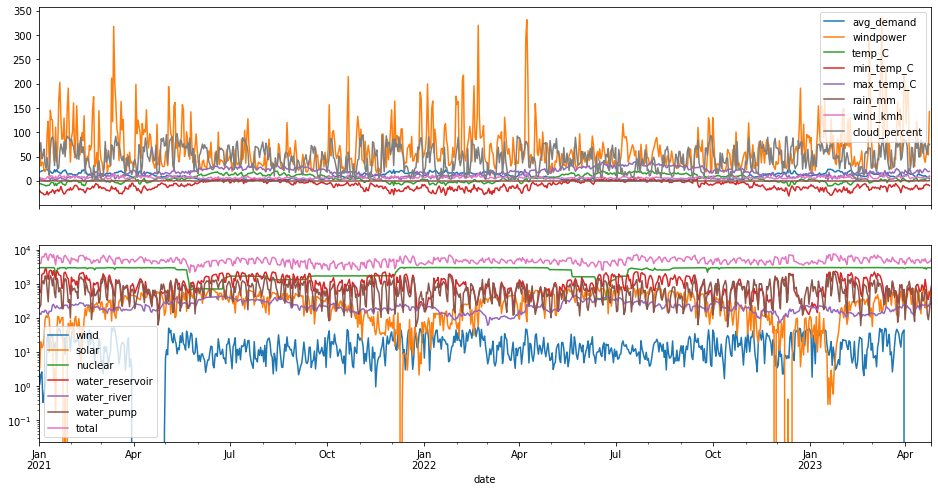

In [6]:
fig,axes = plt.subplots(2,1,figsize=(16,8),sharex=True)

ax = axes[0]
input_features.plot(ax=ax)
ax = axes[1]
target_features.plot(ax=ax)
ax.set_yscale("log")

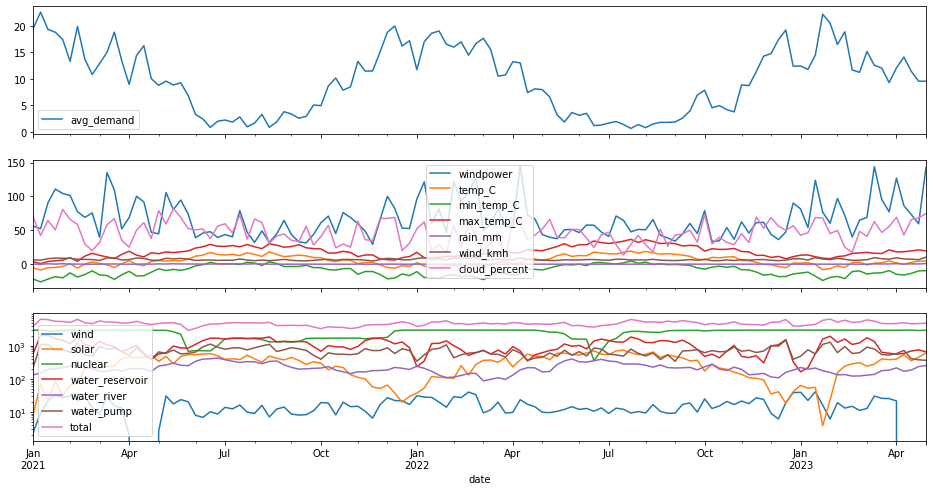

In [7]:
fig,axes = plt.subplots(3,1,figsize=(16,8),sharex=True)

ax = axes[0]
input_features.iloc[:,:1].resample('W').mean().plot(ax=ax)
ax = axes[1]
input_features.iloc[:,1:].resample('W').mean().plot(ax=ax)
ax = axes[2]
target_features.resample('W').mean().plot(ax=ax)
ax.set_yscale("log")

In [8]:
input_features_weekly = input_features.resample('W').mean()
target_features_weekly = target_features.resample('W').mean()

valid_input_features_ts = input_features_weekly.dropna(axis="index", how='any').index
valid_target_features_ts = target_features_weekly.dropna(axis="index", how='any').index

joined_index = valid_input_features_ts.intersection(valid_target_features_ts)



pls2 = sklearn.cross_decomposition.PLSRegression(n_components=2)

# Data for prediction (fitter can not use the columns-name, so we use seperate variables)
input_features_columns = input_features_weekly.columns
target_features_columns = target_features_weekly.columns
pls2 = pls2.fit(
    input_features_weekly.loc[joined_index,:], 
    target_features_weekly.loc[joined_index,:],
)

In [9]:
Y_pred = pls2.predict(input_features.loc[:,input_features_columns])
Y_pred = pd.DataFrame(Y_pred, index = input_features.index,columns=target_features_columns)
Y_pred

,wind,solar,nuclear,water_reservoir,water_river,water_pump,total
date,,,,,,,
2021-01-01 00:00:00+00:00,18.912153,49.219749,3152.447413,983.419702,120.956753,784.869032,5109.824801
2021-01-02 00:00:00+00:00,20.355533,73.604606,3139.131912,957.080205,131.782089,758.257397,5080.211742
2021-01-03 00:00:00+00:00,14.163959,13.059092,3099.998963,1074.621547,102.406525,852.105475,5156.355562
2021-01-04 00:00:00+00:00,14.426955,-24.427512,3189.177671,1065.487638,88.141465,866.582430,5199.388647
2021-01-05 00:00:00+00:00,14.286771,-40.525750,3220.466994,1066.626419,81.773091,875.495273,5218.122797
...,...,...,...,...,...,...,...
2023-04-20 00:00:00+00:00,14.008435,351.926289,2355.362110,1112.762741,233.485860,697.574635,4765.120070
2023-04-21 00:00:00+00:00,15.767077,385.575188,2330.534980,1081.077285,248.200641,663.335481,4724.490652
2023-04-22 00:00:00+00:00,17.117332,368.364321,2405.516586,1052.299720,242.828620,656.887528,4743.014107


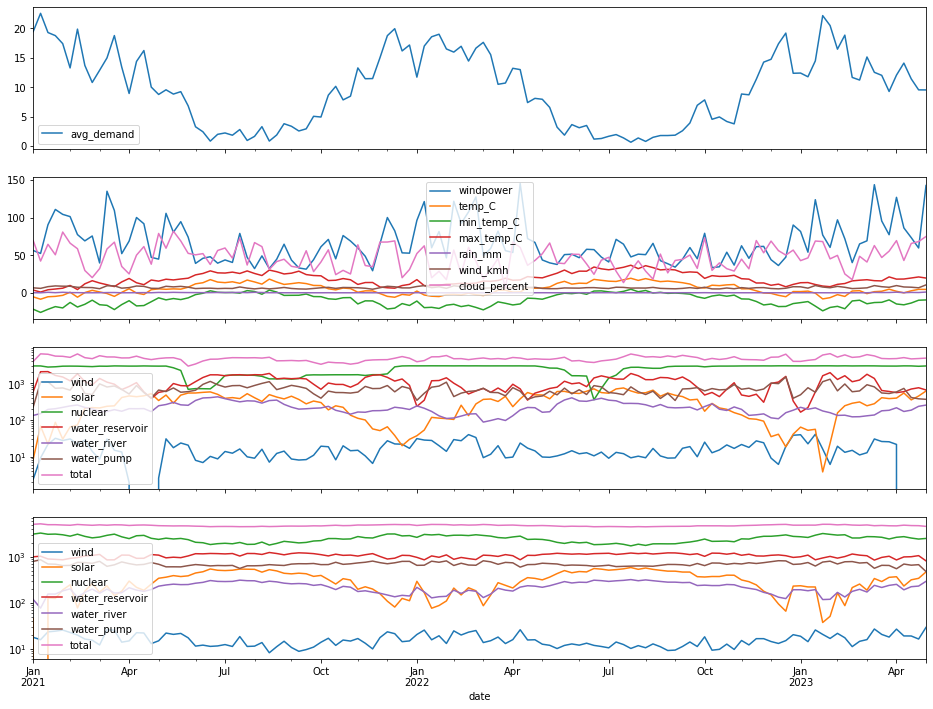

In [10]:
fig,axes = plt.subplots(4,1,figsize=(16,12),sharex=True)

ax = axes[0]
input_features.iloc[:,:1].resample('W').mean().plot(ax=ax)
ax = axes[1]
input_features.iloc[:,1:].resample('W').mean().plot(ax=ax)
ax = axes[2]
target_features.resample('W').mean().plot(ax=ax)
ax.set_yscale("log")
ax = axes[3]
Y_pred.resample('W').mean().plot(ax=ax)
ax.set_yscale("log")